In [74]:
import numpy as np
import pandas as pd

from feature_engineering import extract_brand

import matplotlib.pyplot as plt
import seaborn as sns

import pickle

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error


from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor


In [96]:
# Restore previously stored datasets from the notebook checkpoint
%store  -r X_train
X_train = X_train

%store -r X_val
X_val = X_val

%store -r y_train
y_train = y_train

%store -r y_val
y_val = y_val

%store -r X_test
X_test = X_test

%store -r y_test
y_test = y_test

## Model Evaluation

In [99]:
def score_regressor(
    X_train,
    y_train,
    X_val,
    y_val,
    model,
    n_splits=5,
    random_state=42
):
    """
    Evaluate a regression model using:
    - Cross-validation on training data (stability)
    - Training performance (fit quality)
    - Validation performance (generalization)
    """

    # Convert pandas inputs to numpy if needed
    X_train = X_train.to_numpy() if hasattr(X_train, "to_numpy") else X_train
    y_train = y_train.to_numpy() if hasattr(y_train, "to_numpy") else y_train
    X_val   = X_val.to_numpy()   if hasattr(X_val, "to_numpy")   else X_val
    y_val   = y_val.to_numpy()   if hasattr(y_val, "to_numpy")   else y_val

    # -----------------------
    # Cross-validation (TRAIN)
    # -----------------------
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    cv_r2 = cross_val_score(
        model, X_train, y_train, cv=kf, scoring="r2"
    )

    cv_rmse = -cross_val_score(
        model, X_train, y_train, cv=kf,
        scoring="neg_root_mean_squared_error"
    )

    print(
        f"Training CV R2: {cv_r2.mean():.4f} ± {cv_r2.std():.4f}, "
        f"Training CV RMSE: {cv_rmse.mean():.4f} ± {cv_rmse.std():.4f}"
    )

    # -----------------------
    # Train on full training set
    # -----------------------
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    # Training metrics
    r2_train = r2_score(y_train, y_train_pred)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))

    # Validation metrics
    r2_val = r2_score(y_val, y_val_pred)
    rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))

    print(
        f"Training R2: {r2_train:.4f}, Training RMSE: {rmse_train:.4f}"
    )
    print(
        f"Validation R2: {r2_val:.4f}, Validation RMSE: {rmse_val:.4f}"
    )

    # -----------------------
    # Return results for reuse
    # -----------------------
    return {
        "cv_r2_mean": cv_r2.mean(),
        "cv_r2_std": cv_r2.std(),
        "cv_rmse_mean": cv_rmse.mean(),
        "cv_rmse_std": cv_rmse.std(),
        "train_r2": r2_train,
        "train_rmse": rmse_train,
        "val_r2": r2_val,
        "val_rmse": rmse_val
    }

### Linear Regression

In [107]:
linear_model = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LinearRegression())
])

### Descision Tree Regressor

In [108]:
dt_model = DecisionTreeRegressor(
    random_state=42
)

### RandomForest

In [109]:
rf_model = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

### XGBoost

In [110]:
xgb_model = XGBRegressor(
    objective="reg:squarederror",
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    random_state=42
)

In [112]:
results = []

results.append(
    {"model": "Linear Regression", **score_regressor(X_train, y_train, X_val, y_val, linear_model)}
)
results.append(
    {"model": "Decision Tree", **score_regressor(X_train, y_train, X_val, y_val, dt_model)}
)
results.append(
    {"model": "Random Forest", **score_regressor(X_train, y_train, X_val, y_val, rf_model)}
)
results.append(
    {"model": "XGBoost", **score_regressor(X_train, y_train, X_val, y_val, xgb_model)}
)

pd.DataFrame(results)[
    ["model", "cv_rmse_mean", "cv_rmse_std", "val_rmse", "val_r2"]
].sort_values("val_rmse")

Training CV R2: 0.8127 ± 0.0186, Training CV RMSE: 6067.6983 ± 313.6762
Training R2: 0.8154, Training RMSE: 6041.8751
Validation R2: 0.7982, Validation RMSE: 5569.5782
Training CV R2: 0.8201 ± 0.0153, Training CV RMSE: 5952.7373 ± 365.6603
Training R2: 1.0000, Training RMSE: 69.9932
Validation R2: 0.8152, Validation RMSE: 5330.4748
Training CV R2: 0.9030 ± 0.0068, Training CV RMSE: 4373.8941 ± 245.3959
Training R2: 0.9874, Training RMSE: 1581.1959
Validation R2: 0.8847, Validation RMSE: 4211.0743
Training CV R2: 0.9007 ± 0.0074, Training CV RMSE: 4423.0271 ± 249.4914
Training R2: 0.9666, Training RMSE: 2568.9094
Validation R2: 0.8887, Validation RMSE: 4136.2856


,model,cv_rmse_mean,cv_rmse_std,val_rmse,val_r2
3,XGBoost,4423.027051,249.491382,4136.285577,0.888721
2,Random Forest,4373.894109,245.395947,4211.074320,0.884660
1,Decision Tree,5952.737272,365.660270,5330.474808,0.815190
0,Linear Regression,6067.698253,313.676249,5569.578188,0.798239


The evaluation function was improved to include cross-validated metrics for stability analysis, explicit training metrics to assess model fit, and a separate validation evaluation to measure generalization on unseen data. Additional metrics such as R² were added to complement RMSE and provide a more complete performance view.

These changes ensure robust model comparison, prevent optimistic bias,
and enable clear detection of underfitting and overfitting.

## Model Selection

In [113]:
best_model = RandomForestRegressor(random_state=42
)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation
cross_val_r2 = cross_val_score(
    best_model, X_train, y_train, cv=kf, scoring="r2"
)

cross_val_rmse = -cross_val_score(
    best_model, X_train, y_train, cv=kf,
    scoring="neg_root_mean_squared_error"
)

print(
    f"Training CV R2: {cross_val_r2.mean():.4f}, "
    f"Training CV RMSE: {cross_val_rmse.mean():.4f}"
)

# Train model
best_model.fit(X_train, y_train)

# Predictions
y_train_pred = best_model.predict(X_train)
y_val_pred = best_model.predict(X_val)

# Metrics
r2_train = r2_score(y_train, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))

r2_val = r2_score(y_val, y_val_pred)
rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))

print(
    f"Training R2: {r2_train:.4f}, Training RMSE: {rmse_train:.4f}"
)
print(
    f"Validation R2: {r2_val:.4f}, Validation RMSE: {rmse_val:.4f}"
)

Training CV R2: 0.9024, Training CV RMSE: 4386.4198
Training R2: 0.9869, Training RMSE: 1609.1862
Validation R2: 0.8845, Validation RMSE: 4213.9365


Although XGBoost achieved slightly higher predictive performance, Random Forest
was selected as the final model due to its comparable accuracy, stronger stability,
and lower sensitivity to hyperparameters and less complex.

### Tune Model with Hyper-Parameter

In [114]:
# Define the hyperparameter search space for Random Forest
# The grid focuses on controlling model complexity and ensemble size
param_grid = {
    "n_estimators": [200, 400],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2]
}
# Perform grid search with cross-validation to find the best hyperparameters
grid_search = GridSearchCV(
    estimator=best_model,
    param_grid=param_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)   
print("Best parameters found:", grid_search.best_params_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 400}


In [115]:
best_model_tuned = grid_search.best_estimator_

### Train model with best parameters found

In [ ]:
best_model_tuned = grid_search.best_estimator_
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation
cross_val_r2 = cross_val_score(
    best_model_tuned, X_train, y_train, cv=kf, scoring="r2"
)

cross_val_rmse = -cross_val_score(
    best_model_tuned, X_train, y_train, cv=kf,
    scoring="neg_root_mean_squared_error"
)

print(
    f"Training CV R2: {cross_val_r2.mean():.4f}, "
    f"Training CV RMSE: {cross_val_rmse.mean():.4f}"
)

# Train model
best_model_tuned.fit(X_train, y_train)

# Predictions
y_train_pred = best_model_tuned.predict(X_train)
y_val_pred = best_model_tuned.predict(X_val)

# Metrics
r2_train = r2_score(y_train, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))

r2_val = r2_score(y_val, y_val_pred)
rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))

print(
    f"Training R2: {r2_train:.4f}, Training RMSE: {rmse_train:.4f}"
)
print(
    f"Validation R2: {r2_val:.4f}, Validation RMSE: {rmse_val:.4f}"
)

Training CV R2: 0.9030, Training CV RMSE: 4373.2750
Training R2: 0.9741, Training RMSE: 2261.0738
Validation R2: 0.8849, Validation RMSE: 4207.1727


In [117]:
final_model = best_model_tuned

In [119]:
# Save the list of training feature names
# This ensures feature consistency during inference or deployment
train_features = X_train.columns.tolist()
with open("../models/train_features.pkl", "wb") as f:
    pickle.dump(train_features, f)

### Final Evaluation of Model

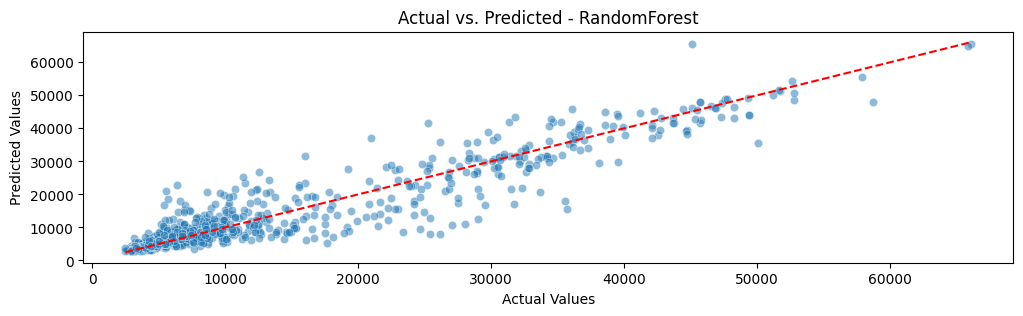

In [120]:
# Create a scatter plot to compare actual vs predicted values
# This helps visually assess model accuracy and bias
plt.figure(figsize=(12, 3))

sns.scatterplot(
    x=y_val,
    y=y_val_pred,
    alpha=0.5
)

plt.plot(
    [y_val.min(), y_val.max()],
    [y_val.min(), y_val.max()],
    "--",
    color="red"
)

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted - RandomForest")
plt.show()

The scatter plot of actual versus predicted prices shows a strong alignment
along the diagonal, indicating good predictive performance. Some dispersion
is observed for high-priced vehicles, which is expected due to market variability.

In [121]:
best_rf = grid_search.best_estimator_

### Feature importance 

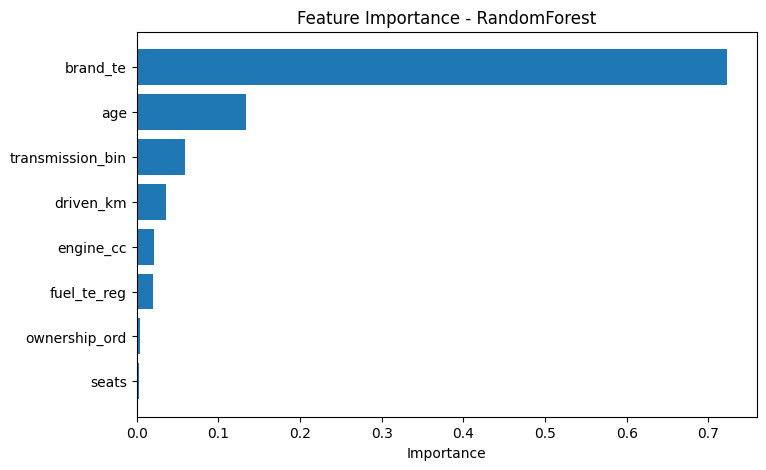

In [122]:
# Extract feature importance values from the trained Random Forest model
importances = best_rf.feature_importances_
features = X_train.columns

fi = pd.DataFrame({
    "feature": features,
    "importance": importances
}).sort_values(by="importance", ascending=False)

plt.figure(figsize=(8, 5))
plt.barh(fi["feature"], fi["importance"])
plt.gca().invert_yaxis()
plt.title("Feature Importance - RandomForest")
plt.xlabel("Importance")
plt.show()


Feature importance analysis shows that brand and vehicle age are the dominant
drivers of price prediction.

In [123]:
residuals = y_val - y_val_pred

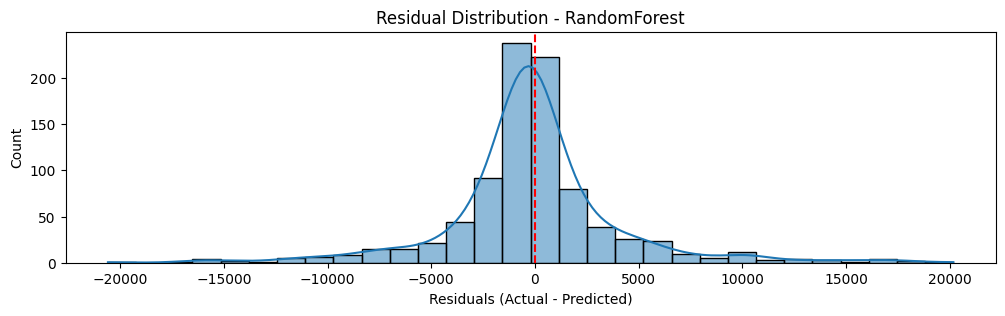

In [124]:
# Plot the distribution of residuals to assess model errors
plt.figure(figsize=(12, 3))

sns.histplot(residuals, bins=30, kde=True)
# Reference line at zero to indicate perfect predictions
plt.axvline(0, color="red", linestyle="dashed")
plt.xlabel("Residuals (Actual - Predicted)")
plt.title("Residual Distribution - RandomForest")
plt.show()


The residual distribution is centered around zero and approximately symmetric,
indicating low bias and good overall model calibration. Some larger residuals
are observed for high-priced vehicles, which is expected due to limited data
in the premium segment.

## Apply Model on Test Data

In [125]:
# Brand target encoding
with open("../models/brand_te.pkl", "rb") as f:
    brand_te = pickle.load(f)

# Fuel target encoding (regularized)
with open("../models/fuel_te_reg.pkl", "rb") as f:
    fuel_te_reg = pickle.load(f)

# Ownership encoder (ordinal mapping)
with open("../models/ownership_encoder.pkl", "rb") as f:
    ownership_mapping = pickle.load(f)

# Transmission encoder (binary)
with open("../models/transmission_encoder.pkl", "rb") as f:
    transmission_mapping = pickle.load(f)

In [ ]:
# recreate age as in training
CURRENT_YEAR = 2024
X_test["age"] = CURRENT_YEAR - X_test["manufacture"]

# delete features not used in training
X_test = X_test.drop(
    columns=["manufacture", "km_per_cc", "cc_per_seat"],
    errors="ignore"
)

In [128]:
# Encode ownership as an ordinal numerical feature
X_test["ownership_ord"] = X_test["ownership"].map(ownership_mapping)

# Encode transmission as a binary feature
X_test["transmission_bin"] = X_test["transmission"].map(transmission_mapping)


# Retrieve parameters for fuel target encoding
fuel_median = fuel_te_reg["fuel_median"]
global_median = fuel_te_reg["global_median"]
alpha = fuel_te_reg["alpha"]

# Apply smoothed target encoding for fuel type
# Unseen categories fall back to the global median
X_test["fuel_te_reg"] = X_test["fuel_type"].map(
    lambda x: alpha * fuel_median.get(x, global_median)
              + (1 - alpha) * global_median
)


# Extract brand name from car_name
X_test["brand"] = X_test["car_name"].apply(extract_brand)

# Apply target encoding for brand
# Unseen brands are filled with the global median price
X_test["brand_te"] = X_test["brand"].map(brand_te)
X_test["brand_te"] = X_test["brand_te"].fillna(global_median)


# Drop original categorical columns no longer needed for prediction
X_test = X_test.drop(
    columns=["ownership", "transmission", "fuel_type", "car_name", "brand"],
    errors="ignore"
)


# Ensure all training features exist in the test set
# Missing columns are added with zero values for safety
for col in train_features:
    if col not in X_test.columns:
        X_test[col] = 0


# Reorder columns to match the exact training feature order
X_test = X_test[train_features]

In [129]:
# Generate predictions on the unseen test set
y_pred = final_model.predict(X_test)

# Evaluate model performance on the test data
r2_test = r2_score(y_test, y_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))

# Display final test performance metrics
print(f"Test R2: {r2_test:.4f}, Test RMSE: {rmse_test:.4f}")

Test R2: 0.8374, Test RMSE: 5653.9420


## CheckPoint

In [130]:
pickle.dump(final_model, open("../models/final_model.pkl", "wb"))